# Missing mass estimation exercise notebook

## Let's get an (unknown) urn of balls.

In [2]:
import sys
sys.path.append("notebooks")
from distributil import rand_hexstr     # Import an UNKNOWN urn of balls
                                        # Ball = 32 hexadecimal string
n = 10                                  # Number of balls (samples) = 10
print(f"{n} balls (hexadecimal strings) from the urn:")
for i in range(n):
    print(f"| sample {i + 1:2d}th: {rand_hexstr()}")

10 balls (hexadecimal strings) from the urn:
| sample  1th: a7f1a385f0efd29176a8efea6e25cbdd
| sample  2th: 39086afeaa3b47aca39d0b57407dc5be
| sample  3th: a7f1a385f0efd29176a8efea6e25cbdd
| sample  4th: a7f1a385f0efd29176a8efea6e25cbdd
| sample  5th: 81e72ab27894bb7356524dcefb005dda
| sample  6th: 39086afeaa3b47aca39d0b57407dc5be
| sample  7th: 39086afeaa3b47aca39d0b57407dc5be
| sample  8th: 0cd8597d3946c2a64dfc3e90864bb284
| sample  9th: 98fb386a3ff278fcbb22838cdfbc07aa
| sample 10th: a7f1a385f0efd29176a8efea6e25cbdd


### Frequencies of balls in the urn

Number of unique strings: 211
Top 3 frequencies: [4042, 1081, 1069]
Bottom 3 frequencies: [1, 1, 1]


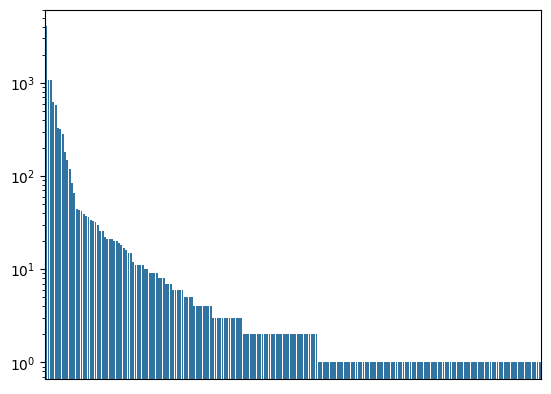

In [3]:
n = 10000

freq_dict = {}
for i in range(n):
    sample = rand_hexstr()
    if sample in freq_dict:
        freq_dict[sample] += 1
    else:
        freq_dict[sample] = 1

import matplotlib.pyplot as plt
import seaborn as sns

num_unique = len(freq_dict)
print(f"Number of unique strings: {num_unique}")
print(
    f"Top 3 frequencies: {sorted(list(freq_dict.values()), reverse=True)[:3]}"
)
print(f"Bottom 3 frequencies: {sorted(list(freq_dict.values()))[:3]}")
freqs = sorted(list(freq_dict.values()), reverse=True)
fig, ax = plt.subplots()
sns.barplot(x=list(range(len(freqs))), y=freqs, ax=ax)
ax.set_xticks([])
ax.set_yscale("log")
plt.show()

## Let's estimate the probability of sampling an unseen ball

### Good-Turing estimator

$$
\textit{estimated probability} = \frac{\Phi_1}{n},
$$

where $\Phi_1$ is the number of singletons.

In [4]:
singletons = {k: v for k, v in freq_dict.items() if v == 1}
print(f"The number of strings seen exactly once is {len(singletons)}")
print(f"Good-Turing estimate: {len(singletons)}/{n} = {len(singletons)/n}")

The number of strings seen exactly once is 95
Good-Turing estimate: 95/10000 = 0.0095


## Let's check how many unseen balls are discovered in the next $n$ samples.

In [6]:
num_unseen = 0
num_additional_samples = n
for _ in range(num_additional_samples):
    sample = rand_hexstr()
    if sample not in freq_dict:     # unseen ball
        num_unseen += 1

print(f"The number of unseen strings in next {num_additional_samples} samples: {num_unseen}")
print(f"Prob(unseen) = {num_unseen}/{num_additional_samples} = {num_unseen/num_additional_samples}")

The number of unseen strings in next 10000 samples: 110
Prob(unseen) = 110/10000 = 0.011


# Good-Turing estimate vs. Empirical probability

In [7]:
import numpy as np

num_sample = 200000
samples = [rand_hexstr() for _ in range(num_sample)]

xs = np.logspace(2, 5, 100)
xs = [int(x) for x in xs]
es = []
ps = []
for x in xs:
    seen_freq_dict = dict(zip(*np.unique(samples[:x], return_counts=True)))
    seens = set(seen_freq_dict.keys())
    remain_freq_dict = dict(zip(*np.unique(samples[x:], return_counts=True)))
    unseens = set(remain_freq_dict.keys()) - seens
    num_unseen = np.sum([remain_freq_dict[unseen] for unseen in unseens])
    ps.append(num_unseen / (num_sample - x))
    singletons = {k: v for k, v in seen_freq_dict.items() if v == 1}
    es.append(len(singletons) / x)

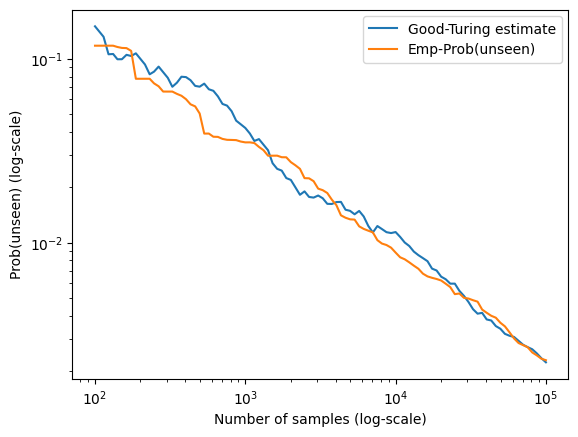

In [8]:
fig, ax = plt.subplots()
ax.plot(xs, es, label="Good-Turing estimate")
ax.plot(xs, ps, label="Emp-Prob(unseen)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of samples (log-scale)")
ax.set_ylabel("Prob(unseen) (log-scale)")
ax.legend()
plt.show()

# Now, what was the UNKNOWN distibution `rand_hexstr`?

### It is actually the result of fuzzing the HTML parser of the `html5lib` library.

### Parser

```py
def html_parser(inp: str) -> None:
    parser = HTMLParser()
    parser.feed(inp)
```

### Coverage recorder
```py
def get_coverage(PUT, inp):
    with Coverage() as cov:
        try:
            PUT(inp)
        except BaseException:
            pass
    return cov
```

In [ ]:
from distributil import html_parser, get_coverage

cov = get_coverage(html_parser, "<html>")
cov.coverage()

### Fuzzing = `rand_hexstr`

```py
def rand_hexstr() -> str:
    # Initialized the fuzzer (random string generator).
    fuzzer = RandomFuzzer(
        min_length=1, max_length=100, char_start=32, char_range=94
    )
    random_input = fuzzer.fuzz() # Generate a random input
    PUT = html_parser
    # Run the random input on the PUT and get the coverage
    cov = get_coverage(PUT, random_input)
    # Return the hash of the coverage
    cov_hash = getTraceHash(cov)
    return cov_hash
```

In [ ]:
h = rand_hexstr(debug=True)